# Sequential model

### Imports

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential

### Instanciate GPU

In [3]:
#use gpu
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)


Num GPUs Available:  1


### Process data

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('original data type : ', X_train.dtype)
print('original data range [', np.min(X_train), ',', np.max(X_train),']')

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

print('\nconverted data type : ', X_train.dtype)
print('converted data range [', np.min(X_train), ',', np.max(X_train),']')

print('\ntraining data shape : ', X_train.shape)
print('testing data shape  : ', X_test.shape)

original data type :  uint8
original data range [ 0 , 255 ]

converted data type :  float32
converted data range [ 0.0 , 1.0 ]

training data shape :  (50000, 32, 32, 3)
testing data shape  :  (10000, 32, 32, 3)


In [5]:
n_classes = 10
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


### Create model

In [6]:
model = Sequential()

input_shape = X_train.shape[1:]

# Integrate the initial layer setup inside the loop by using a flag or condition
first_layer_added = False

for block in range(4):  # 4 blocks
    for layer in range(3):  # 3 Conv2D → relu → BN per block
        if not first_layer_added:
            # Add the first Conv2D with the input_shape defined
            model.add(Conv2D(64, (3, 3), padding='same', strides=1, input_shape=input_shape, name=f'conv2d_{block*3+layer}'))
            first_layer_added = True
        else:
            # Subsequent Conv2D layers do not require input_shape
            model.add(Conv2D(64, (3, 3), padding='same', strides=1, name=f'conv2d_{block*3+layer}'))
        
        model.add(Activation('relu', name=f'activation_{block*3+layer}'))
        model.add(BatchNormalization(name=f'batch_normalization_{block*3+layer}'))
    
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, name=f'max_pooling2d_{block}'))
    model.add(Dropout(0.3, name=f'dropout_{block}'))

model.add(Flatten(name='flatten'))
model.add(Dense(256, activation='relu', name='dense_1'))
model.add(Dropout(0.3, name='dropout_final'))
model.add(Dense(n_classes, activation='softmax', name='outputs'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary to verify the structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_0 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 activation_0 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_0 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                        

### Train model

In [7]:
E = 10                # number of epochs
B = 64                # batch size
V = 0.2               # validation split

checkpoint_callback = ModelCheckpoint(
    'best_model_a.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

log = model.fit(X_train, Y_train, batch_size=B, epochs=E,
               verbose=1, validation_data=(X_test, Y_test),callbacks=[checkpoint_callback])

Epoch 1/10
782/782 [==============================] - ETA: 0s - loss: 1.7039 - accuracy: 0.3753
Epoch 1: val_accuracy improved from -inf to 0.50220, saving model to best_model_a.h5
782/782 [==============================] - 25s 29ms/step - loss: 1.7039 - accuracy: 0.3753 - val_loss: 1.4380 - val_accuracy: 0.5022
Epoch 2/10
781/782 [============================>.] - ETA: 0s - loss: 1.2084 - accuracy: 0.5705
Epoch 2: val_accuracy improved from 0.50220 to 0.60660, saving model to best_model_a.h5
782/782 [==============================] - 37s 48ms/step - loss: 1.2083 - accuracy: 0.5705 - val_loss: 1.1214 - val_accuracy: 0.6066
Epoch 3/10
782/782 [==============================] - ETA: 0s - loss: 0.9745 - accuracy: 0.6597
Epoch 3: val_accuracy improved from 0.60660 to 0.68230, saving model to best_model_a.h5
782/782 [==============================] - 33s 41ms/step - loss: 0.9745 - accuracy: 0.6597 - val_loss: 0.9164 - val_accuracy: 0.6823
Epoch 4/10
781/782 [============================>.] 

### Evaluate model

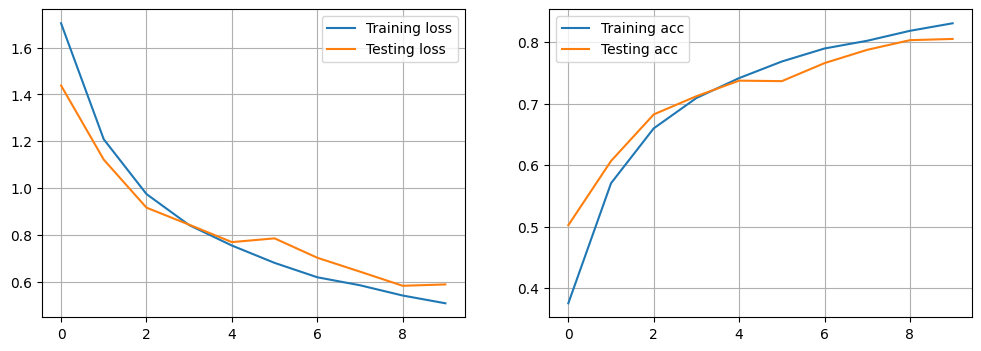

In [8]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

In [13]:
train_acc = log.history["accuracy"]
loss_test, metric_test = model.evaluate(X_test, Y_test, verbose=0)
print(f'Train accuracy : {train_acc[-1]}')
print('Test accuracy:', metric_test)

Train accuracy : 0.8304600119590759
Test accuracy: 0.8604000210762024
